<a href="https://colab.research.google.com/github/adhello007/ML-Projects/blob/main/Covid_19_X_Ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/education454/datasets.git


Cloning into 'datasets'...
remote: Enumerating objects: 2301, done.
remote: Total 2301 (delta 0), reused 0 (delta 0), pack-reused 2301
Receiving objects: 100% (2301/2301), 1.31 GiB | 16.90 MiB/s, done.
Updating files: 100% (2295/2295), done.


In [2]:
from keras.preprocessing.image  import ImageDataGenerator #to augment images 
import numpy as np 
import matplotlib.pyplot as plt 

In [3]:
import os 
main_dir = '/content/datasets/Data'

test_dir = os.path.join(main_dir,'test')

train_dir = os.path.join(main_dir,'train')

train_covid_dir =os.path.join(train_dir,'COVID19')

train_normal_dir = os.path.join(train_dir,'NORMAL')

test_covid_dir =os.path.join(test_dir,'COVID19')

test_normal_dir = os.path.join(test_dir,'NORMAL')

In [4]:
train_covid_names = os.listdir(train_covid_dir) #created a list of all the image names 
#in the train covid directory

train_normal_names = os.listdir(train_normal_dir)

In [5]:
len(train_covid_names)

545

In [6]:
train_covid_names[:10]

['COVID19(103).jpg',
 'COVID19(502).jpg',
 'COVID19(558).jpg',
 'COVID19(492).jpg',
 'COVID19(201).jpg',
 'COVID19(519).jpg',
 'COVID19(141).jpg',
 'COVID19(281).jpg',
 'COVID19(496).jpg',
 'COVID19(501).jpg']

Lets Visualize the images 

In [7]:
import matplotlib.image as mpimg 

rows = 4
cols = 4 #we need a grid of 16 images 

fig = plt.gcf() #get current file 
fig.set_size_inches(12,12)
#creating a list of 8 images of each covid and normal pics paths. 
covid_pic = [os.path.join(train_covid_dir,filename) for filename in train_covid_names[0:8]]

normal_pic = [os.path.join(train_normal_dir,filename) for filename in train_normal_names[0:8]]

print(covid_pic)
print(normal_pic)

['/content/datasets/Data/train/COVID19/COVID19(103).jpg', '/content/datasets/Data/train/COVID19/COVID19(502).jpg', '/content/datasets/Data/train/COVID19/COVID19(558).jpg', '/content/datasets/Data/train/COVID19/COVID19(492).jpg', '/content/datasets/Data/train/COVID19/COVID19(201).jpg', '/content/datasets/Data/train/COVID19/COVID19(519).jpg', '/content/datasets/Data/train/COVID19/COVID19(141).jpg', '/content/datasets/Data/train/COVID19/COVID19(281).jpg']
['/content/datasets/Data/train/NORMAL/NORMAL(890).jpg', '/content/datasets/Data/train/NORMAL/NORMAL(157).jpg', '/content/datasets/Data/train/NORMAL/NORMAL(479).jpg', '/content/datasets/Data/train/NORMAL/NORMAL(1552).jpg', '/content/datasets/Data/train/NORMAL/NORMAL(852).jpg', '/content/datasets/Data/train/NORMAL/NORMAL(447).jpg', '/content/datasets/Data/train/NORMAL/NORMAL(189).jpg', '/content/datasets/Data/train/NORMAL/NORMAL(1332).jpg']


<Figure size 1200x1200 with 0 Axes>

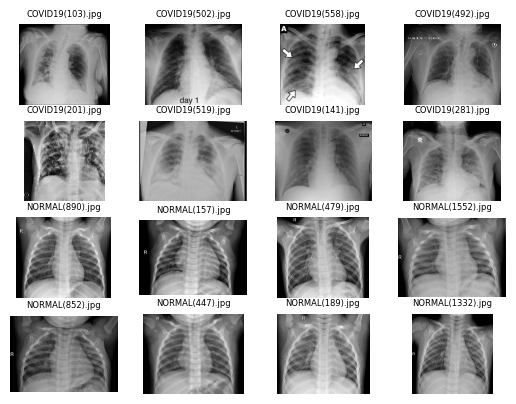

In [8]:
merged_list = covid_pic + normal_pic 
for i, img_path in enumerate(merged_list):
  data = img_path.split('/',6)[6]
  sp  = plt.subplot(rows,cols,i+1)
  sp.axis('Off')
  
  img = mpimg.imread(img_path)
  sp.set_title(data,fontsize=6)
  plt.imshow(img,cmap='gray')

plt.show()

DATA PREPROCESSING AND AUGMENTATION

: we'll split the training dataset into train and val . 
also, we'll augment the images 


In [9]:
dgen_train = ImageDataGenerator(rescale = 1/255., validation_split=0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True)

dgen_val =  ImageDataGenerator(rescale = 1/255.)

dgen_test = ImageDataGenerator(rescale = 1/255.)

train_generator = dgen_train.flow_from_directory(train_dir,target_size=(150,150),
                                                    subset='training',
                                                 batch_size = 32,
                                                 class_mode = 'binary'
) #this is done to load the images 
#from the train directory. we also resized the imges to 150 by 150. 


val_generator = dgen_train.flow_from_directory(train_dir,target_size=(150,150),
                                                    subset='validation',
                                                 batch_size = 32,
                                                 class_mode = 'binary'
)

test_generator = dgen_test.flow_from_directory(test_dir,target_size=(150,150)
                                                    ,
                                                 batch_size = 32,
                                                 class_mode = 'binary'
)

Found 1449 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 484 images belonging to 2 classes.


Here's a more detailed breakdown of what flow_from_directory does:

Takes the directory path as input and automatically detects the classes (subdirectories) and the number of images in each class.

Resizes the images to the specified target_size (in the code snippet, this is (150, 150)).

Converts the images to numpy arrays and scales the pixel values according to the specified rescale factor (in the code snippet, this is 1/255.).

Randomly applies data augmentation techniques like zooming and flipping (if specified in the ImageDataGenerator constructor).

Divides the data into batches of a specified size (in the code snippet, this is batch_size = 32).

Returns batches of data in the form of (x, y) tuples, where x is a numpy array of shape (batch_size, target_size[0], target_size[1], num_channels) containing a batch of preprocessed images and y is a numpy array of shape (batch_size, num_classes) containing the corresponding labels for those images.

Overall, flow_from_directory provides a convenient way to load large datasets of images for training and testing machine learning models using Keras.

In [10]:
type(train_generator)

keras.preprocessing.image.DirectoryIterator

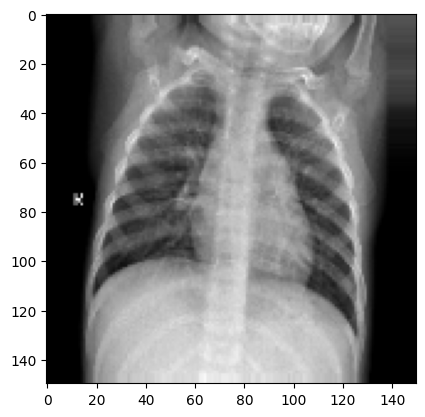

In [11]:
plt.imshow(train_generator[0][0][5]) #first 0 is for the batch number, second 
#is for the image or label which is 0 or 1 and third is the image/label num
#it ranges from 0-32

In [12]:
train_generator[0][1][5] #pneumonia 

1.0

In [13]:
len(train_generator) #46 batches 

46

Create a Model 


In [14]:
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, BatchNormalization, Dropout
from keras.applications import VGG16
vgg_conv = VGG16(weights='imagenet',include_top = False,input_shape=(150,150,3))

58889256/58889256 [==============================] - 3s 0us/step


In [15]:
for layer in vgg_conv.layers:
  layer.trainable = False

In [16]:
model = Sequential()

model.add(vgg_conv)
model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8

In [17]:
from keras.optimizers import Adam 
opt = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99,amsgrad=False)

In [18]:
model.compile(
    optimizer =opt, 
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8

In [19]:
training = model.fit(train_generator,epochs = 5,validation_data = val_generator)

Epoch 1/5
46/46 [==============================] - 67s 1s/step - loss: 0.1731 - accuracy: 0.9199 - val_loss: 0.0967 - val_accuracy: 0.9751
Epoch 2/5
46/46 [==============================] - 57s 1s/step - loss: 0.0514 - accuracy: 0.9800 - val_loss: 0.0467 - val_accuracy: 0.9862
Epoch 3/5
46/46 [==============================] - 54s 1s/step - loss: 0.0401 - accuracy: 0.9862 - val_loss: 0.0525 - val_accuracy: 0.9807
Epoch 4/5
46/46 [==============================] - 55s 1s/step - loss: 0.0326 - accuracy: 0.9896 - val_loss: 0.0429 - val_accuracy: 0.9834
Epoch 5/5
46/46 [==============================] - 52s 1s/step - loss: 0.0415 - accuracy: 0.9827 - val_loss: 0.0338 - val_accuracy: 0.9890


In [20]:
training.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

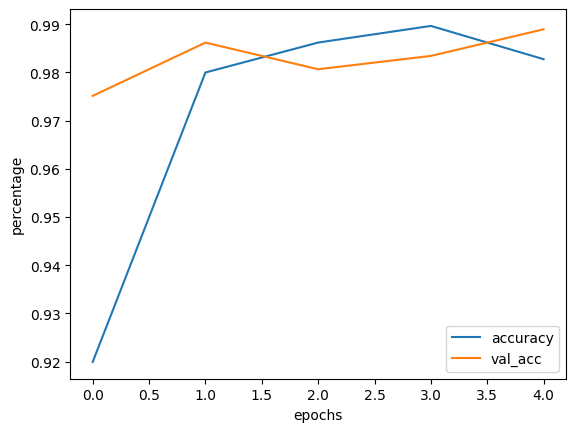

In [21]:
accuracy = training.history['accuracy']
val_acc  = training.history['val_accuracy']
plt.plot(range(len(accuracy)),accuracy,label = "accuracy")
plt.plot(range(len(accuracy)),val_acc,label ="val_acc")
plt.xlabel('epochs')
plt.ylabel('percentage')
plt.legend()
plt.show()

In [23]:
len(val_generator) #12 batches of validation data

12

# Model Evaluation 

In [ ]:
from keras.metrics import Precision,Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
model.evaluate(test_generator)

16/16 [==============================] - 12s 759ms/step - loss: 0.0300 - accuracy: 0.9897


[0.030015043914318085, 0.9896694421768188]

In [ ]:
train_generator

In [25]:
len(test_generator)

16

In [76]:
model.evaluate(test_generator)

16/16 [==============================] - 12s 743ms/step - loss: 0.0186 - accuracy: 0.9938


[0.018607888370752335, 0.9938016533851624]

In [119]:
y_pred = model.predict(test_generator) #predicted all the test values. 

16/16 [==============================] - 17s 1s/step


In [125]:
y_pred = np.round(y_pred)

In [127]:
y_pred[:5]

array([[1.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [115]:
y_true = np.array([])
for i in range(16): #there are 16 batches 
  x,y = test_generator[i]
  y_true = np.concatenate([y_true, y])

In [97]:
y_true.shape 

(484,)

In [98]:
y_true[:20]

array([1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 1., 1.])

In [99]:
y_pred.shape

(484, 1)

Text(95.72222222222221, 0.5, 'Ground Truth')

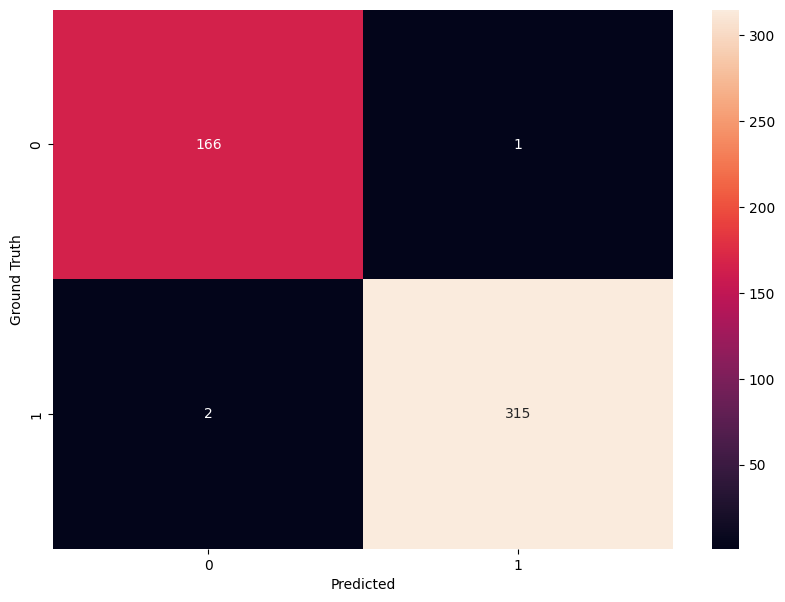

In [126]:
import seaborn as sns 
import tensorflow as tf
cm = tf.math.confusion_matrix(labels=y_true,predictions=y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')